In [1]:
from causadb import CausaDB
from causadb.examples.heating import get_heating_dataset, set_heating, calculate_wasted_heating_cost
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import xgboost as xgb
import plotly.graph_objects as go
from tqdm import tqdm

colors = ['#15C7B8',  '#B13CA0', '#D3D3D3', '#808080']
background_color = '#1b1917'

np.random.seed(42)

# CausaDB Demo - Smart Building Energy Optimisation

In this notebook we'll demonstrate how standard AI & ML tools fail when used for optimising pre-heating and pre-cooling strategies in commercial buildings. We'll then show how CausaDB can be used to solve this problem.

## Background

Large commercial buildings are often so large that they require pre-heating and pre-cooling to achieve an appropriate temperature for either the occupants or the equipment inside. These buildings can be anything from office buildings, warehouses, or even GPU data centers.

However, setting the right HVAC system settings is challenging because it requires predicting the future temperature and energy usage of the building. Current approaches either use simple heuristics or machine learning models to predict the future temperature and energy usage. In this demo, we'll show how these approaches fail to provide accurate predictions and waste both energy and money.

## Dataset

The usual approach to solving the problem of choosing the correct HVAC settings for a building is to use a historical dataset relating to the building. The dataset might usually contain the following columns:

- `day`: The day of the year, indexed from 1 to 365
- `outdoor_temp`: The temperature outside the building
- `indoor_temp`: The temperature inside the building
- `energy`: The overall energy usage of the building
- `heating`: The heating setting of the HVAC system
- etc.

In this demo we'll use a synthetic dataset. This allows us to simulate the impact of taking actions by changing the HVAC settings and observing the impact on the indoor temperature. This is usually not possible in a real-world dataset, and is the reason that standard AI/ML tools fail to solve this problem.

First let's load in our dataset.

In [2]:
data = get_heating_dataset()
data.to_csv("example_heating_data.csv", index=False)
data.head()

,day,outdoor_temp,heating,indoor_temp,energy
0,0,14.50,56.0,19.25,685.0
1,1,13.90,59.0,19.26,708.0
2,2,14.72,56.0,19.38,666.0
3,3,15.63,53.0,17.81,671.0
4,4,13.90,57.0,19.88,700.0


In this dataset, outdoor temperature fluctuates throughout the year, which means that the building will require different heating and cooling settings to maintain a constant indoor temperature.

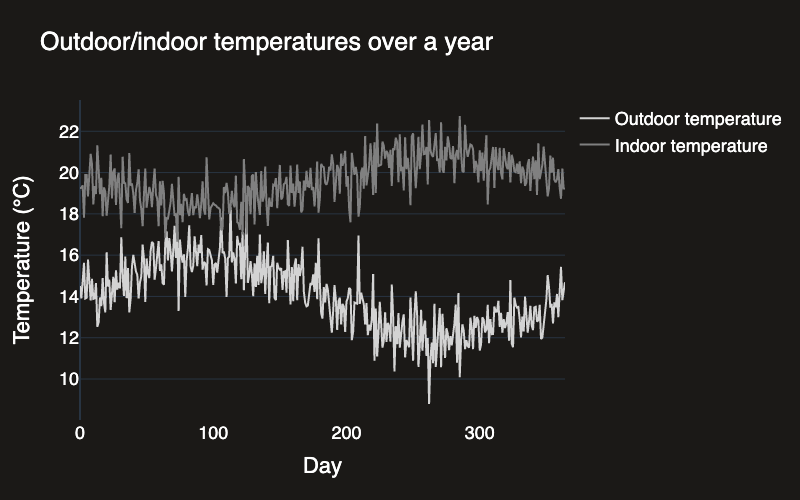

In [3]:
fig = go.Figure()

# Create line plots
fig.add_trace(go.Scatter(y=data["outdoor_temp"], x=data["day"], mode='lines', name='Outdoor temperature', line_width=2, line_color=colors[2]))
fig.add_trace(go.Scatter(y=data["indoor_temp"], x=data["day"], mode='lines', name='Indoor temperature', line_width=2, line_color=colors[3]))

# Update axes properties
fig.update_layout(
    template='plotly_dark',
    paper_bgcolor=background_color,  # Background color for the whole figure
    plot_bgcolor=background_color,   # Background color for the plotting area
    xaxis_title="Day",  # X-axis label
    yaxis_title="Temperature (°C)",  # Y-axis label
    title="Outdoor/indoor temperatures over a year",  # Title of the plot
    font=dict(family="Helvetica", size=18, color="white"),  # Set the font here
    xaxis=dict(showgrid=False),  # Increase X-axis label size
    yaxis=dict(showgrid=True),   # Increase Y-axis label size
    width=800,  # Set the figure width
    height=500,  # Set the figure height
)

# Show plot
fig.show(renderer="png")

## Standard AI Approach

Now we'll take a standard approach to solving this problem by training an XGBoost model to predict the HVAC setting from the outdoor temperature and desired indoor temperature. We'll leave the energy usage out of the model for now, but this would cause additional problems in a real-world scenario (we won't go into this here).

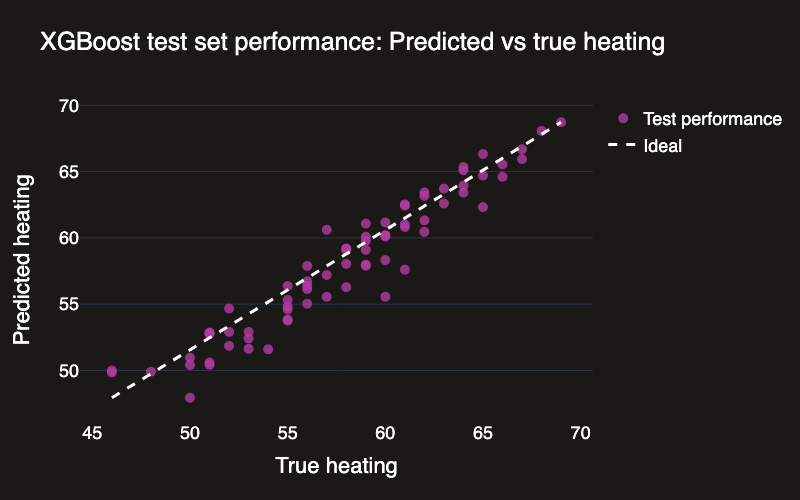

In [4]:
# Train an XGBoost model to predict heating from outdoor_temp, indoor_temp, and energy
X = data[['outdoor_temp', 'indoor_temp']].values
y = data['heating'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

# Plot with plotly
fig = go.Figure()
# Create scatter plot
fig.add_trace(go.Scatter(x=y_test, y=y_pred, mode='markers', name='Test performance',
                         marker=dict(size=10, color=colors[1], opacity=0.8)))
# Create line plot
fig.add_trace(go.Scatter(x=[np.min(y_test), np.max(y_test)], y=[np.min(y_pred), np.max(y_pred)], 
                         mode='lines', name="Ideal", line=dict(color="white", width=3, dash='dash')))
# Update axes properties
fig.update_layout(
    template='plotly_dark',
    paper_bgcolor=background_color,  # Background color for the whole figure
    plot_bgcolor=background_color,   # Background color for the plotting area
    xaxis_title="True heating",  # X-axis label
    yaxis_title="Predicted heating",  # Y-axis label
    title="XGBoost test set performance: Predicted vs true heating",  # Title of the plot
    font=dict(family="Helvetica", size=18, color="white"),  # Set the font here
    xaxis=dict(showgrid=False),  # Increase X-axis label size
    yaxis=dict(showgrid=True),   # Increase Y-axis label size
    width=800,  # Set the figure width
    height=500,  # Set the figure height
)
# Show plot
fig.show(renderer="png")
            

The model performs well on the test set, so let's see how it performs in the "real" world. We'll simulate outdoor temperature data for another year, set a target indoor temperature, and use the model to predict the HVAC settings.

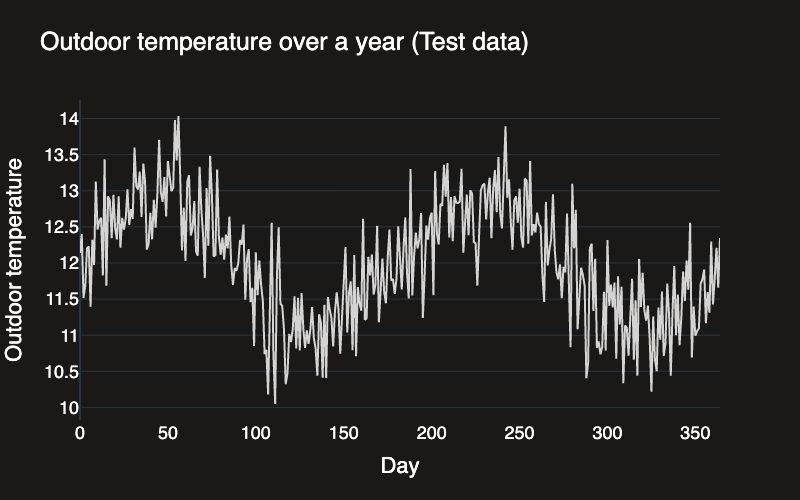

In [5]:
outdoor_temp_test = 12 + np.sin(np.linspace(0, 4*np.pi, 365)) + np.random.normal(0, 0.5, 365)

# Plot with plotly
fig = go.Figure()
# Create scatter plot
fig.add_trace(go.Scatter(x=np.arange(365), y=outdoor_temp_test, mode='lines', name='Outdoor temperature',
                         line=dict(color=colors[2], width=2)))
# Update axes properties
fig.update_layout(
    template='plotly_dark',
    paper_bgcolor=background_color,  # Background color for the whole figure
    plot_bgcolor=background_color,   # Background color for the plotting area
    xaxis_title="Day",  # X-axis label
    yaxis_title="Outdoor temperature",  # Y-axis label
    title="Outdoor temperature over a year (Test data)",  # Title of the plot
    font=dict(family="Helvetica", size=18, color="white"),  # Set the font here
    xaxis=dict(showgrid=False),  # Increase X-axis label size
    yaxis=dict(showgrid=True),   # Increase Y-axis label size
    width=800,  # Set the figure width
    height=500,  # Set the figure height
)
# Show plot
fig.show(renderer="png")

## How does XGBoost perform in the real world?

We can use XGBoost to generate recommendations, and see how well it performs in the real world using simulated interventions.

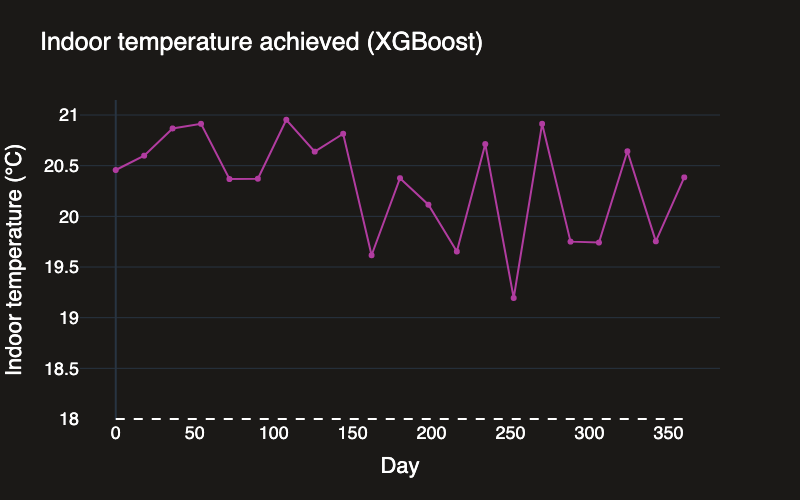

In [6]:
target_indoor_temp = 18

# Predict heating for outdoor_temp = current_outdoor_temp, indoor_temp = target_temp
day_idx = np.arange(0, data.shape[0], data.shape[0]//20)
X = np.stack([outdoor_temp_test, np.repeat(target_indoor_temp, repeats=len(outdoor_temp_test))], axis=1)
heating_pred_xgb = xgb_model.predict(X)
indoor_temp_xgb, energy_xgb = set_heating(heating_pred_xgb, outdoor_temp_test, noise=False)

fig = go.Figure()

# Create line plots
fig.add_trace(go.Scatter(y=indoor_temp_xgb, x=day_idx, mode='lines+markers', name='XGBoost', line_width=2, line_color=colors[1]))

# Add target temperature line
fig.add_shape(type='line',
              x0=day_idx[0], y0=target_indoor_temp, x1=day_idx[-1], y1=target_indoor_temp,
              line=dict(color='white', width=2, dash='dash'))

# Update axes properties
fig.update_layout(
    template='plotly_dark',
    paper_bgcolor=background_color,  # Background color for the whole figure
    plot_bgcolor=background_color,   # Background color for the plotting area
    xaxis_title="Day",  # X-axis label
    yaxis_title="Indoor temperature (°C)",  # Y-axis label
    title="Indoor temperature achieved (XGBoost)",  # Title of the plot
    font=dict(family="Helvetica", size=18, color="white"),  # Set the font here
    xaxis=dict(showgrid=False),  # Increase X-axis label size
    yaxis=dict(showgrid=True),   # Increase Y-axis label size
    width=800,  # Set the figure width
    height=500,  # Set the figure height
)

# Show plot
fig.show(renderer="png")

## How does CausaDB solve this issue?

CausaDB uses causal AI to understand the impact of interventions on the system. This means it can be trusted to provide accurate recommendations for HVAC settings.

To fit a CausaDB model, we'll first initialise the client using the token key provided to all customers. In this case we'll load it from environment variables for security.

In [7]:
# Load the CausaDB token and initialise the client.
CAUSADB_TOKEN = os.environ.get("CAUSADB_TOKEN")
causadb = CausaDB(token=CAUSADB_TOKEN)

Fitting a CausaDB model can be done in a few lines of code. The key steps are:
1) Register a dataset with the CausaDB cloud
2) Define the model structure (how the variables are connected to each other)
3) Fit the model to the dataset

In [8]:
# Register data with CausaDB
causadb \
    .add_data("example-heating-data") \
    .from_pandas(data)

# Define a causal model (can also be done in the UI)
model = causadb.create_model("example-heating-model")
model.set_nodes(["outdoor_temp", "heating", "indoor_temp", "energy"])
model.set_edges([
    ("outdoor_temp", "heating"),
    ("outdoor_temp", "indoor_temp"),
    ("heating", "indoor_temp"),
    ("heating", "energy"),
    ("indoor_temp", "energy")
])

# Train the model on example-heating-data
model.train("example-heating-data")

print(f"Model status: {model.status()}")

Model status: trained


With the CausaDB model trained, then we can use it to generate recommendations for HVAC settings. The `find_best_action` function will return the best action to take in order to achieve a target outcome.

In [9]:
best_actions = model.find_best_actions(
    targets={"indoor_temp": 19},
    actionable=["heating"],
    fixed={"outdoor_temp": 16}
)

achieved_indoor_temp = set_heating(best_actions["heating"].values, np.array([16]), noise=False)[0]

print(f"Best heating setting: {best_actions['heating'].values[0]:.2f}")
print(f"Indoor temperature achieved: {achieved_indoor_temp[0]:.2f}°C")


Best heating setting: 53.88
Indoor temperature achieved: 18.87°C


Now we'll compare the recommendations made by the CausaDB model with the XGBoost model, and see how well the two approaches perform in the real world on the test year.

In [10]:
# Find best actions using CausaDB (do it for only a subsample across days because optimisation is expensive)
best_actions_causadb = []
outdoor_temps_causadb = []
# for i in day_idx: # Replace with tqdm
for i in tqdm(day_idx):
    best_actions = model.find_best_actions(
        targets={"indoor_temp": target_indoor_temp},
        actionable=["heating"],
        fixed={"outdoor_temp": outdoor_temp_test[i]}
    )
    best_actions_causadb.append(best_actions.values[0])
    outdoor_temps_causadb.append(outdoor_temp_test[i])

best_actions_causadb = np.array(best_actions_causadb).flatten()
outdoor_temps_causadb = np.array(outdoor_temps_causadb).flatten()
indoor_temp_causadb, energy_causadb = set_heating(best_actions_causadb, outdoor_temps_causadb, noise=False)


  0%|          | 0/21 [00:00<?, ?it/s]

100%|██████████| 21/21 [00:15<00:00,  1.40it/s]


Let's plot the recommendations from CausaDB against the standard AI approach.

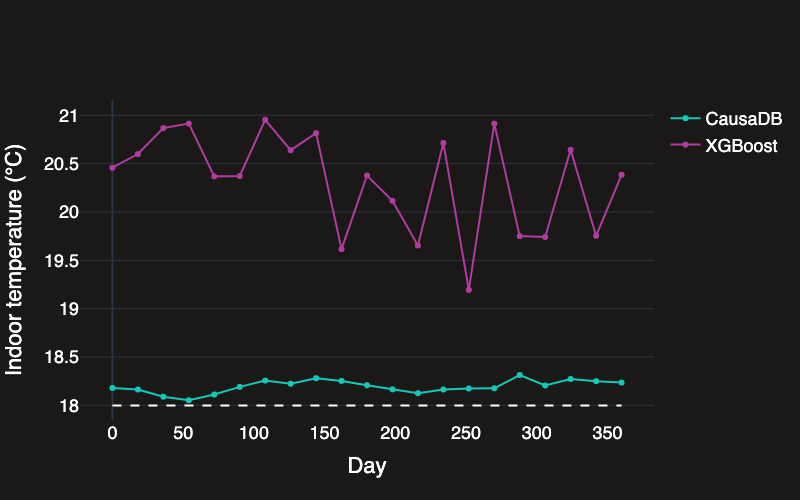

In [11]:

fig = go.Figure()

# Create line plots
fig.add_trace(go.Scatter(y=indoor_temp_causadb, x=day_idx, mode='lines+markers', name='CausaDB', line_width=2, line_color=colors[0]))
fig.add_trace(go.Scatter(y=indoor_temp_xgb, x=day_idx, mode='lines+markers', name='XGBoost', line_width=2, line_color=colors[1]))

# Add target temperature line
fig.add_shape(type='line',
              x0=day_idx[0], y0=target_indoor_temp, x1=day_idx[-1], y1=target_indoor_temp,
              line=dict(color='white', width=2, dash='dash'))

# Update axes properties
fig.update_layout(
    template='plotly_dark',
    paper_bgcolor=background_color,  # Background color for the whole figure
    plot_bgcolor=background_color,   # Background color for the plotting area
    xaxis_title="Day",  # X-axis label
    yaxis_title="Indoor temperature (°C)",  # Y-axis label
    font=dict(family="Helvetica", size=18, color="white"),  # Set the font here
    xaxis=dict(showgrid=False),  # Increase X-axis label size
    yaxis=dict(showgrid=True),   # Increase Y-axis label size
    width=800,  # Set the figure width
    height=500,  # Set the figure height
)

# Show plot
fig.show(renderer="png")

We can see that the CausaDB model performs well in the real world, maintaining a constant indoor temperature close to the target. The XGBoost model, despite performing well on the test data, fails to maintain a constant indoor temperature near to the target. This is because the underlying distribution of the data are different to the training data when interventions are made in the real world. This is why standard AI/ML tools perform poorly for predicting the outcomes of actions in the real world.

In [12]:
# Mean absolute error from target indoor temp
mae = np.mean(np.abs(data["indoor_temp"] - target_indoor_temp))
print(f'Mean absolute error in original data (Human): {mae:.2f}°C')

# Mean absolute error from target indoor temp with recommended HVAC
mae = np.mean(np.abs(indoor_temp_xgb - target_indoor_temp))
print(f'Mean absolute error with recommended HVAC (XGB): {mae:.2f}°C')

# Mean absolute error from target indoor temp with recommended HVAC
mae = np.mean(np.abs(indoor_temp_causadb - target_indoor_temp))
print(f'Mean absolute error with recommended HVAC (CausaDB): {mae:.2f}°C')


Mean absolute error in original data (Human): 1.72°C
Mean absolute error with recommended HVAC (XGB): 2.46°C
Mean absolute error with recommended HVAC (CausaDB): 0.20°C


We can use a simple volumetric model to calculate the energy wastage and cost of the two approaches. We can see that the CausaDB model saves energy and money compared to the XGBoost model.

In [13]:
cost_original, cost_original_daily, _ = calculate_wasted_heating_cost(data["indoor_temp"], target_indoor_temp)
cost_xgb, cost_xgb_daily, _ = calculate_wasted_heating_cost(indoor_temp_xgb, target_indoor_temp)
cost_causadb, cost_causadb_daily, _ = calculate_wasted_heating_cost(indoor_temp_causadb, target_indoor_temp)

print(f'Wasted heating cost in original data (Human): £{cost_original:.2f}')
print(f'Wasted heating cost with recommended HVAC (XGB): £{cost_xgb:.2f}')
print(f'Wasted heating cost with recommended HVAC (CausaDB): £{cost_causadb:.2f}')

print(f'Cost reduction with CausaDB vs. XGB: £{cost_xgb - cost_causadb:.2f}')
print(f'Percentage cost reduction with CausaDB vs. XGB: {100 * (cost_xgb - cost_causadb) / cost_xgb:.2f}%')
print(f'Cost reduction with CausaDB vs. Human: £{cost_original - cost_causadb:.2f}')
print(f'Percentage cost reduction with CausaDB vs. Human: {100 * (cost_original - cost_causadb) / cost_original:.2f}%')

Wasted heating cost in original data (Human): £352521.45
Wasted heating cost with recommended HVAC (XGB): £506169.30
Wasted heating cost with recommended HVAC (CausaDB): £40125.70
Cost reduction with CausaDB vs. XGB: £466043.59
Percentage cost reduction with CausaDB vs. XGB: 92.07%
Cost reduction with CausaDB vs. Human: £312395.75
Percentage cost reduction with CausaDB vs. Human: 88.62%


## Conclusion



This notebook is a short introduction to how CausaDB can be used in smart building energy management. We've built an accompanying Streamlit app to demonstrate how CausaDB can be used to optimise HVAC settings in real time in a deployed system. Check out the application code in the `app.py` file and test out the live app by visiting [causadb-examples-smart-building.streamlit.app](https://causadb-examples-smart-building.streamlit.app/).

CausaDB is not just for HVAC systems. The same principles can be applied to a wide range of problems in domains as diverse as marketing, logistics, healthcare, and more. To find out more about CausaDB and to get in touch, visit our site at [causa.tech](https://causa.tech).